<a href="https://colab.research.google.com/github/2203A52119/2119_DeepLearning/blob/main/deeplearning__project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/2
242/242 ━━━━━━━━━━━━━━━━━━━━ 60s 216ms/step - accuracy: 0.8236 - loss: 0.3605 - val_accuracy: 0.9917 - val_loss: 0.0270
Epoch 2/2
242/242 ━━━━━━━━━━━━━━━━━━━━ 53s 221ms/step - accuracy: 0.9945 - loss: 0.0179 - val_accuracy: 0.9984 - val_loss: 0.0123
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step


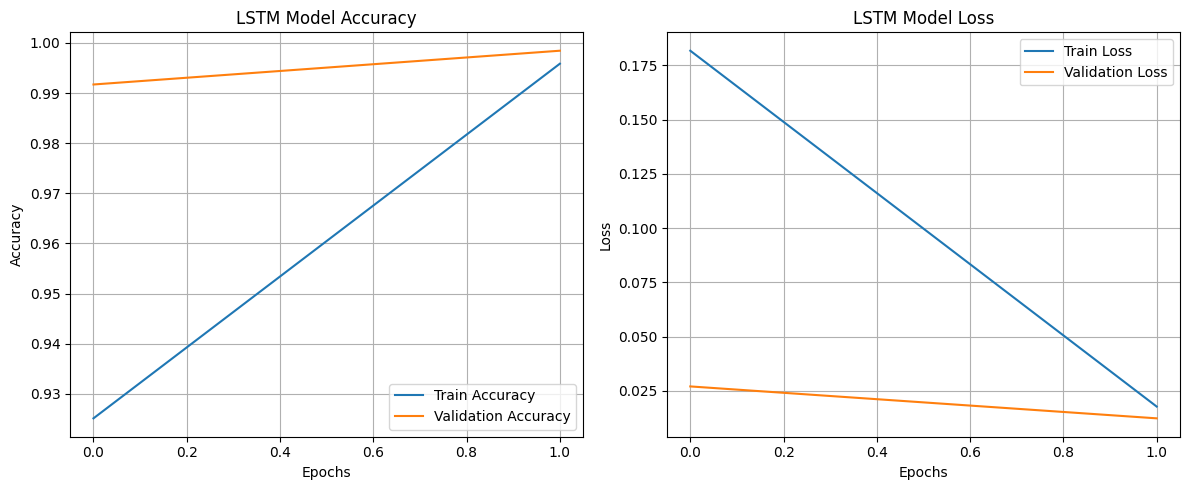


LSTM Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       975
           1       1.00      1.00      1.00       955

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       975
           1       0.99      0.99      0.99       955

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



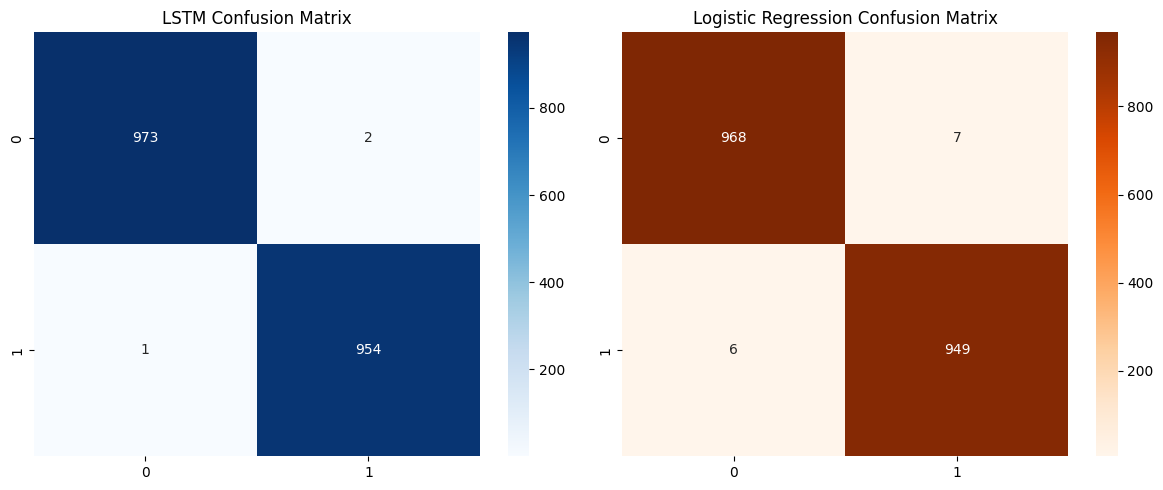

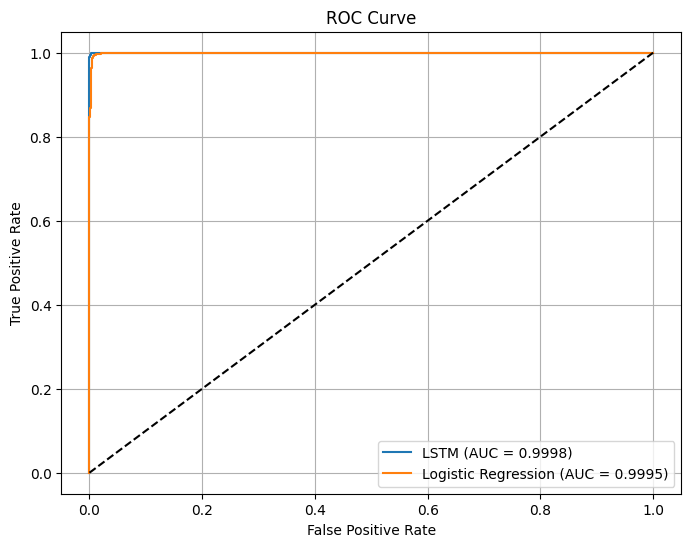


📊 Model Performance Comparison:

   Metric   LSTM Logistic Regression
 Accuracy 0.9984              0.9933
Precision 0.9979              0.9927
   Recall 0.9990              0.9937
 F1 Score 0.9984              0.9932
      AUC 0.9998              0.9995


In [ ]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 📥 Load and clean dataset
df = pd.read_csv("/content/spam.csv", encoding="latin-1")[["v1", "v2"]]
df.columns = ["label", "message"]

# ⚖️ Balance dataset
ham_df = df[df["label"] == "ham"]
spam_df = df[df["label"] == "spam"]
spam_upsampled = resample(spam_df, replace=True, n_samples=len(ham_df), random_state=42)
df_balanced = pd.concat([ham_df, spam_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# 🔢 Label encoding
le = LabelEncoder()
df_balanced["label"] = le.fit_transform(df_balanced["label"])  # ham=0, spam=1

# 📊 Train/test split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df_balanced["message"], df_balanced["label"], test_size=0.2, random_state=42
)

# ----------------------------------
# 🧠 LSTM Model
# ----------------------------------
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

max_len = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

vocab_size = len(tokenizer.word_index) + 1

lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# 🏋️‍♂️ Training the LSTM model
history = lstm_model.fit(X_train_pad, y_train, epochs=2, batch_size=32, validation_data=(X_test_pad, y_test), verbose=1)

# 🔍 LSTM predictions
lstm_probs = lstm_model.predict(X_test_pad).ravel()
lstm_preds = (lstm_probs > 0.5).astype(int)

# ----------------------------------
# Plotting Accuracy and Loss graphs
# ----------------------------------
# Plotting Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ----------------------------------
# 🤖 Logistic Regression Model
# ----------------------------------
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)
lr_probs = lr_model.predict_proba(X_test_tfidf)[:, 1]
lr_preds = (lr_probs > 0.5).astype(int)

# ----------------------------------
# 🧾 Metrics and Comparison
# ----------------------------------
def model_metrics(name, y_true, y_pred, y_probs):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = auc(fpr, tpr)
    print(f"\n{name} Classification Report:\n", classification_report(y_true, y_pred))
    return acc, prec, rec, f1, fpr, tpr, auc_score

lstm_results = model_metrics("LSTM", y_test, lstm_preds, lstm_probs)
lr_results = model_metrics("Logistic Regression", y_test, lr_preds, lr_probs)

# 📊 Confusion Matrix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, lstm_preds), annot=True, fmt='d', cmap='Blues')
plt.title("LSTM Confusion Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, lr_preds), annot=True, fmt='d', cmap='Oranges')
plt.title("Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()

# 📈 ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(lstm_results[4], lstm_results[5], label=f"LSTM (AUC = {lstm_results[6]:.4f})")
plt.plot(lr_results[4], lr_results[5], label=f"Logistic Regression (AUC = {lr_results[6]:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# 📊 Comparison Table
comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"],
    "LSTM": [f"{x:.4f}" for x in lstm_results[:4]] + [f"{lstm_results[6]:.4f}"],
    "Logistic Regression": [f"{x:.4f}" for x in lr_results[:4]] + [f"{lr_results[6]:.4f}"]
})
print("\n📊 Model Performance Comparison:\n")
print(comparison_df.to_string(index=False))


In [ ]:
from scipy import stats
import numpy as np

# Use message lengths for statistical tests
X_train_len_ham = [len(msg) for msg in X_train_text[y_train == 0]]
X_train_len_spam = [len(msg) for msg in X_train_text[y_train == 1]]

# Z-Test
mean_diff = np.mean(X_train_len_spam) - np.mean(X_train_len_ham)
std1, std2 = np.std(X_train_len_spam, ddof=1), np.std(X_train_len_ham, ddof=1)
n1, n2 = len(X_train_len_spam), len(X_train_len_ham)
se_diff = np.sqrt(std1**2/n1 + std2**2/n2)
z_score = mean_diff / se_diff
z_p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

# T-Test (Welch’s)
t_stat, t_p_value = stats.ttest_ind(X_train_len_spam, X_train_len_ham, equal_var=False)

# ANOVA
f_stat, f_p_value = stats.f_oneway(X_train_len_spam, X_train_len_ham)

# Display results
print("📊 Z-Test")
print(f"Z-Score: {z_score:.4f}, P-Value: {z_p_value:.4f}")

print("\n📊 T-Test (Welch’s)")
print(f"T-Statistic: {t_stat:.4f}, P-Value: {t_p_value:.4f}")

print("\n📊 ANOVA Test")
print(f"F-Statistic: {f_stat:.4f}, P-Value: {f_p_value:.4f}")

# Type I and Type II Error Explanation
print("\n❗ Type I Error: Rejecting a true null hypothesis (False Positive).")
print("Example: Predicting spam when it’s actually ham.")

print("❗ Type II Error: Failing to reject a false null hypothesis (False Negative).")
print("Example: Predicting ham when it’s actually spam.")


📊 Z-Test
Z-Score: 64.4316, P-Value: 0.0000

📊 T-Test (Welch’s)
T-Statistic: 64.4316, P-Value: 0.0000

📊 ANOVA Test
F-Statistic: 4164.8002, P-Value: 0.0000

❗ Type I Error: Rejecting a true null hypothesis (False Positive).
Example: Predicting spam when it’s actually ham.
❗ Type II Error: Failing to reject a false null hypothesis (False Negative).
Example: Predicting ham when it’s actually spam.


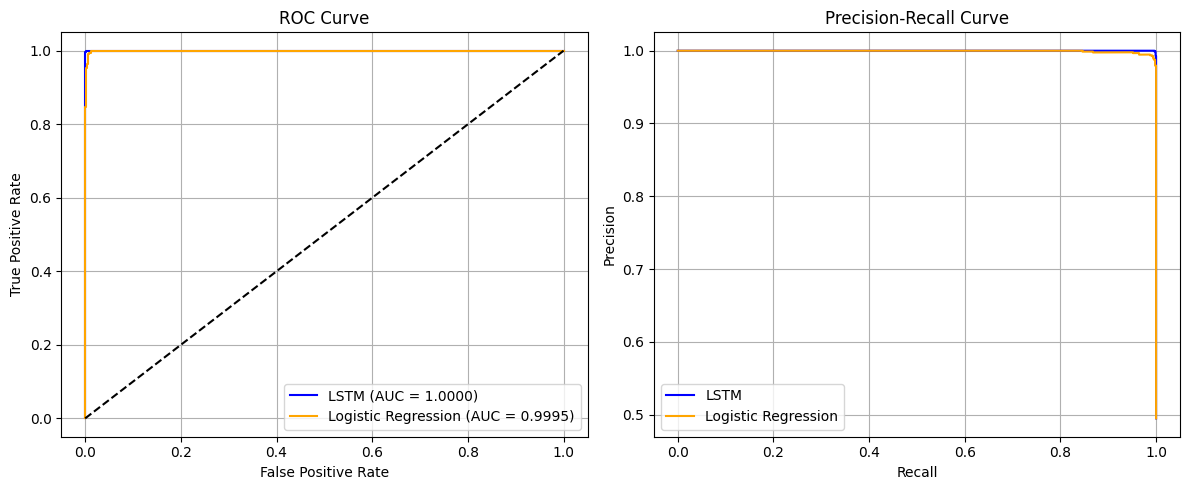

In [ ]:
from sklearn.metrics import precision_recall_curve

# --- ROC Curve ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lstm_results[4], lstm_results[5], label=f"LSTM (AUC = {lstm_results[6]:.4f})", color='blue')
plt.plot(lr_results[4], lr_results[5], label=f"Logistic Regression (AUC = {lr_results[6]:.4f})", color='orange')
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()

# --- Precision-Recall Curve ---
plt.subplot(1, 2, 2)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lstm_precision, lstm_recall, _ = precision_recall_curve(y_test, lstm_probs)

plt.plot(lstm_recall, lstm_precision, label="LSTM", color='blue')
plt.plot(lr_recall, lr_precision, label="Logistic Regression", color='orange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
